In [116]:
import pandas as pd                                       #importing pandas
import numpy as np                                        #importing numpy
import copy                                               
import random
import matplotlib.pyplot as plt                           #importing matplotlib 
import seaborn as sns                                     #importing seaborn
from sklearn.model_selection import train_test_split      #importing scikit-learn's function for data splitting
from sklearn.linear_model import LinearRegression         #importing scikit-learn's linear regressor function
from sklearn.neural_network import MLPRegressor           #importing scikit-learn's neural network function
from sklearn.ensemble import GradientBoostingRegressor    #importing scikit-learn's gradient booster regressor function
from sklearn.metrics import mean_squared_error            #importing scikit-learn's root mean squared error function for model evaluation
from sklearn.model_selection import cross_validate        #improting scikit-learn's cross validation function

In [2]:
boxscores = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/boxscores_dataset.csv')     #load boxscores dataset
# running locally
# boxscores = pd.read_csv('boxscores_dataset.csv')     #load boxscores dataset
boxscores = boxscores[(boxscores.playMin>=3) | (boxscores.playMin.isnull())]

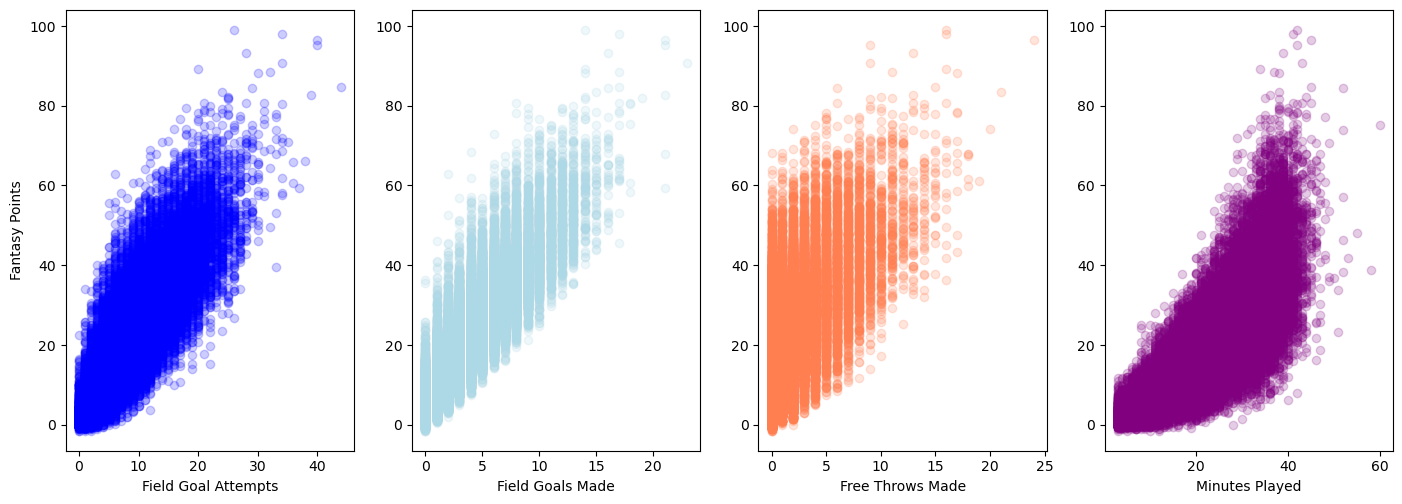

In [3]:
fig, (FGA, FGM, FTM, Min) = plt.subplots(1, 4, figsize=(14,5))
fig.tight_layout()

FGA.scatter(boxscores['playFGA'], boxscores['FantasyPoints'], c='blue', alpha = .2)
FGM.scatter(boxscores['playFGM'], boxscores['FantasyPoints'], c='lightblue', alpha = .2)
FTM.scatter(boxscores['playFTM'], boxscores['FantasyPoints'], c='coral', alpha = .2)
Min.scatter(boxscores['playMin'], boxscores['FantasyPoints'], c='purple', alpha = .2)

FGA.set_xlabel('Field Goal Attempts')
FGM.set_xlabel('Field Goals Made')
FTM.set_xlabel('Free Throws Made')
Min.set_xlabel('Minutes Played')

FGA.set_ylabel('Fantasy Points');

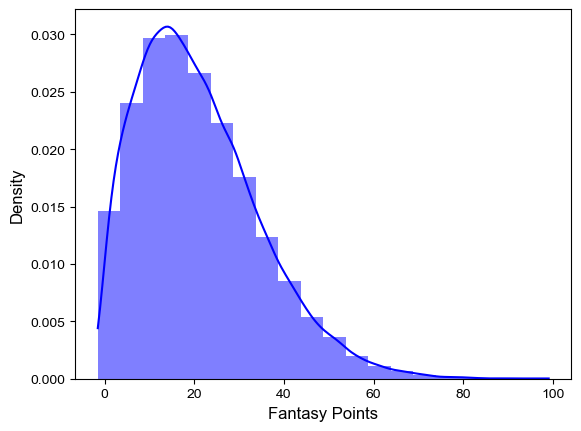

In [4]:
hplot = sns.histplot(boxscores['FantasyPoints'], color="blue", label="Fantasy Points", kde=True, stat="density", linewidth=0, bins=20)
hplot.set_xlabel("Fantasy Points", fontsize = 12)
hplot.set_ylabel("Density", fontsize = 12)
sns.set(rc={"figure.figsize":(14, 5)})

In [5]:
horizon=3

for column_name in ['playPTS','playAST','playTO','playSTL','playBLK','playTRB','playFGA','playFTA','play2P%','play3P%','playFT%','playMin','teamDayOff','FantasyPoints']:
    boxscores['moving' + column_name] = boxscores.groupby(['playDispNm'])[column_name].transform(lambda x: x.rolling(horizon, 1).mean().shift(1))                           #lagged moving average of numeric features 

In [6]:
boxscores.dropna(subset = ["movingplayPTS"], inplace=True)  

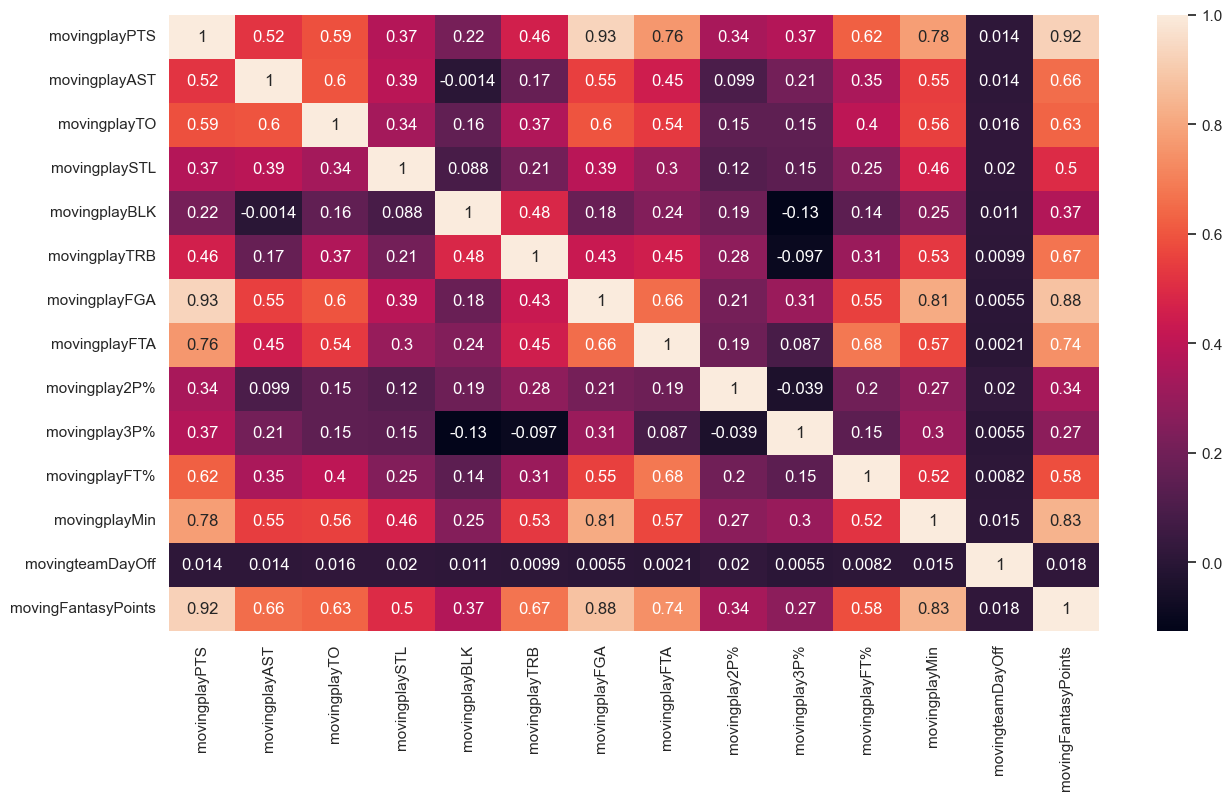

In [7]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(boxscores[['movingplayPTS', 'movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFGA','movingplayFTA','movingplay2P%','movingplay3P%','movingplayFT%','movingplayMin','movingteamDayOff','movingFantasyPoints']].corr(),annot=True)
plt.show()

In [8]:
boxscores['dummyTeamLoc'] = pd.get_dummies(data=boxscores['teamLoc'],drop_first=True)    #1 if the game is a home game, 0 if it is an away game
boxscores['dummyplayStat'] = pd.get_dummies(data=boxscores['playStat'],drop_first=True)  #1 if the player starts, 0 if the player comes from the bench

In [9]:
forecasting_data = boxscores[boxscores.gmDate != '2017-12-25']  #for model training, we exclude observation on December 25, 2017

In [10]:
X = forecasting_data[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]  #select the features that will be used for model training
y = forecasting_data['FantasyPoints']  #target set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)      #dataset splitting

linear_regressor = LinearRegression()                                                         #load linear regressor
linear_regressor.fit(X_train, y_train)                                                        #train the linear regression model
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

mlp = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu')                               #load neural network
mlp.fit(X_train,y_train)                                                                      #train the neural network with a ReLU function and two hidden layers with 5 nodes each
mlp_validation = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

gb = GradientBoostingRegressor()                                                              #load a gradient boosting regressor
gb.fit(X_train, y_train)                                                                      #train a gradient boosting model
gb_validation = cross_validate(gb, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

In [11]:
gb_validation['test_score']                            #print CV test score across each fold

array([0.50927152, 0.49924901, 0.48130738, 0.49770318, 0.50056331])

In [12]:
linear_regression_predictions = linear_regressor.predict(X_test)                              #make predictions based on the test set for the linear regression model
mlp_predictions = mlp.predict(X_test)                                                         #make predictions based on the test set for the neural network model
gb_predictions = gb.predict(X_test)                                                           #make predictions based on the test set for the gradient boosting model

linear_regression_mse = mean_squared_error(y_test, linear_regression_predictions)             #calculate the MSE for the linear regression model
mlp_mse = mean_squared_error(y_test, mlp_predictions)                                         #calculate the MSE for the neural network model
gb_mse = mean_squared_error(y_test, gb_predictions)                                           #calculate the MSE for the gradient boosting model

results = {'Linear Regression':[linear_regression_mse],'ReLU Neural Network':[mlp_mse],'Gradient Boosting Regressor':[gb_mse]}
modeling_results = pd.DataFrame(data=results,index=['MSE'])

modeling_results

,Linear Regression,ReLU Neural Network,Gradient Boosting Regressor
MSE,91.077312,90.772893,90.669258


Text(968.0882352941177, 0.5, 'Gradient Boosting Residual')

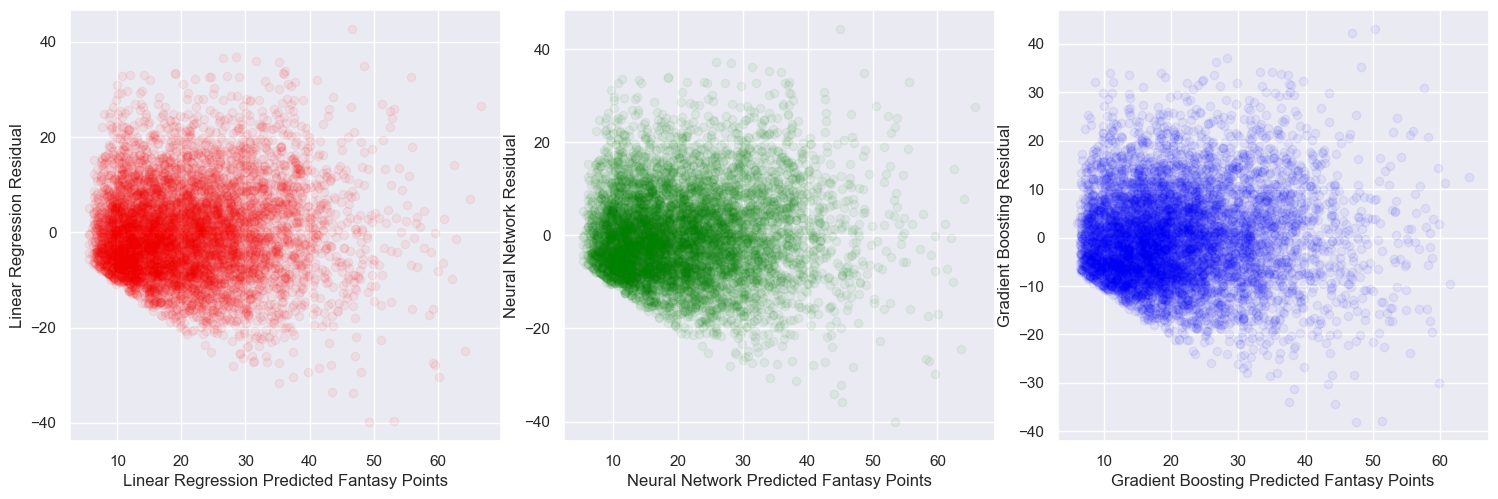

In [13]:
fig, (LR, FNN, GBR) = plt.subplots(1, 3,figsize=(15,5));
fig.tight_layout()

LR.scatter(x = linear_regression_predictions, y = y_test - linear_regression_predictions,color='red',alpha=0.06)
FNN.scatter(x = mlp_predictions, y = y_test - mlp_predictions, color='green',alpha=0.06)
GBR.scatter(x = gb_predictions, y = y_test - gb_predictions, color='blue',alpha=0.06)

LR.set_xlabel('Linear Regression Predicted Fantasy Points')
FNN.set_xlabel('Neural Network Predicted Fantasy Points')
GBR.set_xlabel('Gradient Boosting Predicted Fantasy Points')

LR.set_ylabel('Linear Regression Residual')
FNN.set_ylabel('Neural Network Residual')
GBR.set_ylabel('Gradient Boosting Residual')

In [14]:
gb_final = GradientBoostingRegressor(random_state=4)                                                             
gb_final.fit(X, y)   

optimization_dataset = boxscores
optimization_dataset['PredictedFantasyPoints'] = gb_final.predict(boxscores[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]) 

player_results = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/target_games.csv')
# player_results = pd.read_csv('target_games.csv')

predicted_fantasy_points = (
    optimization_dataset.query("gmDate == '2017-12-25'")
    [["playDispNm", "PredictedFantasyPoints"]]
)

player_results = pd.merge(
    left = player_results,
    right = predicted_fantasy_points,
    left_on = "Player",
    right_on = "playDispNm",
)

In [73]:
pd.set_option('display.expand_frame_repr', False)
player_results['Points/Salary Ratio'] = 1000*player_results['PredictedFantasyPoints']/player_results['Salary']    #we multiple the fantasy vs salary ratio by 1000 for better visualization
player_results.sort_values(by='PredictedFantasyPoints',ascending=False).head(5)

,Player,Pos,Team,Opp,Salary,playDispNm,PredictedFantasyPoints,Points/Salary Ratio
4,Joel Embiid,C,PHI,@ NYK,9500,Joel Embiid,51.313689,5.401441
0,James Harden,PG,HOU,@ OKC,11100,James Harden,48.809577,4.397259
1,LeBron James,SF,CLE,@ GSW,11000,LeBron James,48.149718,4.377247
2,Russell Westbrook,PG,OKC,vs HOU,10900,Russell Westbrook,44.007224,4.037360
3,Kevin Durant,SF,GSW,vs CLE,10500,Kevin Durant,43.438575,4.137007


In [74]:
indices = player_results.Player
points = dict(zip(indices, player_results.PredictedFantasyPoints))
salaries = dict(zip(indices, player_results.Salary))
positions = dict(zip(indices, player_results.Pos))

### Restricciones

In [75]:
SALARY_CAP = 30000
POSITIONS = {"PG": 1, "SG": 1, "SF": 1, "PF": 1, "C": 1}

### PARÁMETROS DEL PSO

In [119]:
N = 100  # Número de partículas
it_max = 500  # Iteraciones máximas
c1 = 1  # Peso cognitivo
c2 = 1  # Peso social

### FUNCIÓN OBJETIVO: Ahora sin penalización

In [120]:
def fitness(team):
    """Calcula los fantasy points sin aplicar restricciones."""
    return sum(points[player] for player in team)

### GENERACIÓN DEL EQUIPO VÁLIDO (Asegura restricciones antes de fitness)

In [110]:
def generate_valid_team():
    """Genera un equipo que cumple con todas las restricciones."""
    while True:
        valid_team = []
        for pos in POSITIONS:
            candidates = [p for p in indices if positions[p] == pos]
            valid_team.append(random.choice(candidates))
        
        total_salary = sum(salaries[player] for player in valid_team)
        if total_salary <= SALARY_CAP:
            return valid_team  # Solo devuelve el equipo si cumple con el salario

### DEFINICIÓN DE PARTÍCULA

In [121]:
class Particle:
    def __init__(self):
        self.position = generate_valid_team()
        self.velocity = [0] * len(self.position)  # Inicializar velocidad como una lista vacía
        self.best_position = self.position[:]
        self.best_fitness = fitness(self.position)

### INICIALIZACIÓN DEL ENJAMBRE

In [122]:
particles = [Particle() for _ in range(N)]

### Encontrar la mejor partícula global

In [123]:
gbest_particle = max(particles, key=lambda p: p.best_fitness)
gbest_position = gbest_particle.best_position
gbest_fitness = gbest_particle.best_fitness

### PROCESO ITERATIVO DE PSO (Ahora con restricciones en `for`)

In [ ]:
for it in range(it_max):
    for particle in particles:
        new_team = copy.deepcopy(particle.position)
        
        # Este 3 también es un parámetro que podríamos poner random
        # Seleccionamos 3 posiciones aleatorias del equipo para cambiar
        indices_to_change = random.sample(range(len(new_team)), 3)  

        for idx in indices_to_change:
            player = new_team[idx]
            pos_to_change = positions[player]
            
            # Filtrar candidatos para esa posición
            candidates = [p for p in indices if positions[p] == pos_to_change and p != player]

            # Asegurar que siempre haya opciones válidas
            if not candidates:
                candidates = [p for p in indices if positions[p] == pos_to_change]

            # Aplicamos la actualización tipo PSO
            if random.random() < c1 / (c1 + c2):  # Influencia del mejor local
                new_team[idx] = particle.best_position[idx]
            elif random.random() < c2 / (c1 + c2):  # Influencia del mejor global
                new_team[idx] = gbest_position[idx]
            else:  # Exploración aleatoria
                new_team[idx] = random.choice(candidates)
            
        #print(new_team)

        # Verificamos restricciones ANTES de calcular fitness
        total_salary = sum(salaries[player] for player in new_team)
        if total_salary <= SALARY_CAP:
            new_fitness = fitness(new_team)
            #print(new_fitness)

            # Actualizar mejor posición local
            if new_fitness > particle.best_fitness:
                particle.best_position = new_team[:]
                particle.best_fitness = new_fitness

            # Actualizar mejor posición global
            if new_fitness > gbest_fitness:
                gbest_position = new_team[:]
                gbest_fitness = new_fitness
                print(gbest_fitness)

    print(f"Iteración {it + 1}: Mejor puntuación = {gbest_fitness}")

152.2576309277256
155.69328756001423
Iteración 1: Mejor puntuación = 155.69328756001423
Iteración 2: Mejor puntuación = 155.69328756001423
167.9516345585239
Iteración 3: Mejor puntuación = 167.9516345585239
Iteración 4: Mejor puntuación = 167.9516345585239
Iteración 5: Mejor puntuación = 167.9516345585239
Iteración 6: Mejor puntuación = 167.9516345585239
Iteración 7: Mejor puntuación = 167.9516345585239
Iteración 8: Mejor puntuación = 167.9516345585239
168.40148091195533
Iteración 9: Mejor puntuación = 168.40148091195533
Iteración 10: Mejor puntuación = 168.40148091195533
Iteración 11: Mejor puntuación = 168.40148091195533
Iteración 12: Mejor puntuación = 168.40148091195533
Iteración 13: Mejor puntuación = 168.40148091195533
Iteración 14: Mejor puntuación = 168.40148091195533
Iteración 15: Mejor puntuación = 168.40148091195533
Iteración 16: Mejor puntuación = 168.40148091195533
Iteración 17: Mejor puntuación = 168.40148091195533
Iteración 18: Mejor puntuación = 168.40148091195533
Itera

### RESULTADO FINAL

In [125]:
best_team = gbest_position
print("\nEquipo óptimo seleccionado:")
for player in best_team:
    print(f"{player} - Posición: {positions[player]}, FantasyPoints: {points[player]}, Salary: {salaries[player]}")



Equipo óptimo seleccionado:
Jarrett Jack - Posición: PG, FantasyPoints: 27.780012412781506, Salary: 4600
Trevor Ariza - Posición: SG, FantasyPoints: 26.354156526577885, Salary: 5000
Markieff Morris - Posición: SF, FantasyPoints: 25.96558495634552, Salary: 4400
Dario Saric - Posición: PF, FantasyPoints: 40.5054861101437, Salary: 6200
Joel Embiid - Posición: C, FantasyPoints: 51.31368913047382, Salary: 9500
